In [7]:
import sys
sys.path.append('../../')
sys.path.append('../')

from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime

# random seed 고정
random.seed(42)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(42)
else:
    device = torch.device('cuda')
    torch.manual_seed_all(42)

In [8]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403160511 ##############################


In [9]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
tr_batch = 2
vl_batch = 1

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([2, 256, 256, 3])


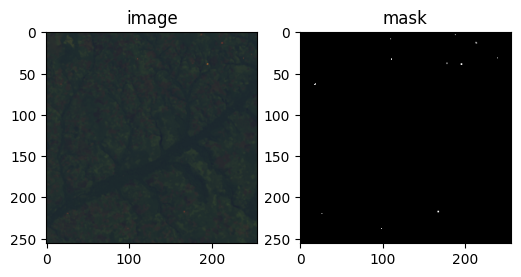

torch.Size([1, 256, 256, 3])


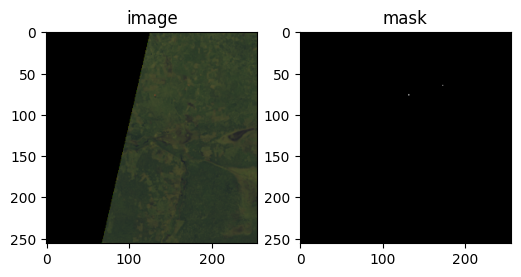

In [10]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [1]:
import sys 
sys.path.append('../')
from networks.swin.vision_transformer import SwinUnet
from networks.swin import config
SwinUnet(config = config)

AttributeError: module 'networks.swin.config' has no attribute 'DATA'

In [1]:
import torch
import torch.nn as nn 
from torchsummary import summary as summary
device = 'cuda'
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')

# # model & cost func & optimizer 정의 
################################ v2~v3 ########################################
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)

################################ v3~ ########################################
# from torchvision.models.segmentation import deeplabv3_resnet50
# from torchsummary import summary
# model = deeplabv3_resnet50(pretrained= True)
# model.classifier = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
# model.to('cuda')
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
model.to(device)
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCELoss()

print(f'device : {device}')
summary(model, input_size=(3, 224, 224))



Using cache found in /home/oj/.cache/torch/hub/pytorch_vision_v0.10.0


NameError: name 'lr_scheduler' is not defined

In [12]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [13]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images)
        print(preds)
        print(masks)
        train_loss = loss(preds, masks)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses > best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass
    
print("Complete")

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [5,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [6,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], thread: [7,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [118,0,0], t

tensor([[[[-1.0739,  0.6102, -0.3054,  ..., -1.4809, -1.0010, -0.8026],
          [ 0.1565,  1.9114,  1.2118,  ..., -0.5173, -0.1718,  0.3893],
          [ 0.5415, -0.3086,  2.0083,  ..., -1.9568, -2.8302,  0.8851],
          ...,
          [-0.0436,  0.7186,  0.5826,  ..., -1.3568, -2.1392,  0.4831],
          [ 0.6575,  0.5367, -0.5382,  ..., -0.2648, -0.5681,  0.5743],
          [-0.0641,  0.2525, -0.6121,  ..., -1.0949, -0.3328,  0.2994]]],


        [[[-1.0932, -0.4822, -0.5768,  ..., -1.3464, -0.7996, -0.6253],
          [-0.4959,  0.9468,  0.9725,  ..., -0.6566, -1.0525, -0.0175],
          [-0.6297,  0.3008,  0.4075,  ..., -1.6846, -2.8577,  0.3033],
          ...,
          [-0.7731,  0.0830,  0.7245,  ..., -0.5834, -2.3437,  0.5808],
          [-0.1764, -0.6576, -0.1966,  ..., -0.5331, -1.8951,  0.0809],
          [-0.7990, -0.1892, -0.3378,  ..., -0.6423, -0.9982,  0.0254]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
 


../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [5,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [11,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [13,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [15,0,0] Assertion `input_val >= zero && input_v

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


`input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [83,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [84,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [85,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [86,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [87,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], thread: [88,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [141,0,0], threa